In [1]:
import os
import json
import urllib

import h5py
import numpy as np
import pickle as pk
from IPython.display import Image, display, clear_output

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.utils.data_utils import get_file

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled)


## Input

In [3]:
first_gate = VGG16(weights='imagenet')
second_gate = load_model('data1a/ft_model.h5')
location_model = load_model('data2a/ft_model.h5')
severity_model = load_model('data3_1/ft_model.h5')

In [4]:
with open('vgg16_cat_list.pk', 'rb') as f:
    cat_list = pk.load(f)

## First Gate Setup - Car or Not?

In [5]:
# from Keras GitHub  
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [6]:
def prepare_img_224(img_path):
    urllib.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [7]:
def car_categories_gate(img_224, model):
    print "Validating that this is a picture of your car..."
    out = model.predict(img_224)
    top = get_predictions(out, top=5)
    for j in top[0]:
        if j[0:2] in cat_list:
            # print j[0:2]
            return True # "Validation complete - proceed to damage evaluation"
    return False # "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

## Second Gate Setup - Damaged or Whole?

In [8]:
def prepare_img_256(img_path):
    urllib.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255
    return x

In [9]:
def car_damage_gate(img_256, model):
    print "Validating that damage exists..."
    pred = model.predict(img_256)
    if pred[0][0] <=.5:
        return True # print "Validation complete - proceed to location and severity determination"
    else:
        return False
        # print "Are you sure that your car is damaged? Please submit another picture of the damage."
        # print "Hint: Try zooming in/out, using a different angle or different lighting"

## Location and Severity Assessment

In [10]:
def location_assessment(img_256, model):
    print "Determining location of damage..."
    pred = model.predict(img_256)
    pred_label = np.argmax(pred, axis=1)
    d = {0: 'Front', 1: 'Rear', 2: 'Side'}
    for key in d.iterkeys():
        if pred_label[0] == key:
            print "Assessment: {} damage to vehicle".format(d[key])
    print "Location assessment complete."

In [11]:
def severity_assessment(img_256, model):
    print "Determining severity of damage..."
    pred = model.predict(img_256)
    pred_label = np.argmax(pred, axis=1)
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.iterkeys():
        if pred_label[0] == key:
            print "Assessment: {} damage to vehicle".format(d[key])
    print "Severity assessment complete."

In [14]:
# load models
def engine():
    while True:
        try:
            print "Submit image link (or type 'exit' to quit)"
            img_path = raw_input("Upload Image File Here:")
            if img_path == 'exit':
                return None
            clear_output()

            img_224 = prepare_img_224(img_path)
            g1 = car_categories_gate(img_224, first_gate)

            display(Image('save.jpg', width=300))

            if g1 is False:
                print "Are you sure this is a picture of your car? Please submit another picture of the damage."
                print "Hint: Try zooming in/out, using a different angle or different lighting."
                break

            img_256 = prepare_img_256(img_path)
            g2 = car_damage_gate(img_256, second_gate)

            if g2 is False:
                print "Are you sure that your car is damaged? Please submit another picture of the damage."
                print "Hint: Try zooming in/out, using a different angle or different lighting."
                break

            x = location_assessment(img_256, location_model)
            y = severity_assessment(img_256, severity_model)
        except:
            print "Image not accessible. Please try again."
            break

Upload Image File Here:http://ste.india.com/sites/default/files/2016/01/21/452974-monkey.jpg
Validating that this is a picture of your car...


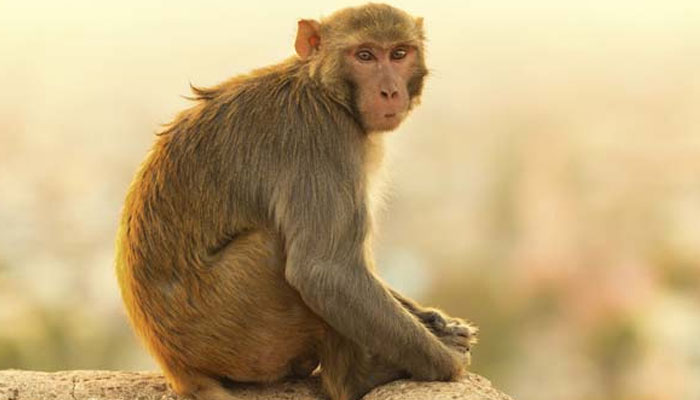

Are you sure this is a picture of your car? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.


In [40]:
engine()

Upload Image File Here:http://com.mazdacdn.com/common/en/assets/innovation/models/img/upcoming-mazda-2/01_mazda_upcoming_mazda2.ts.1501091421576870.jpg?quality=75
Validating that this is a picture of your car...


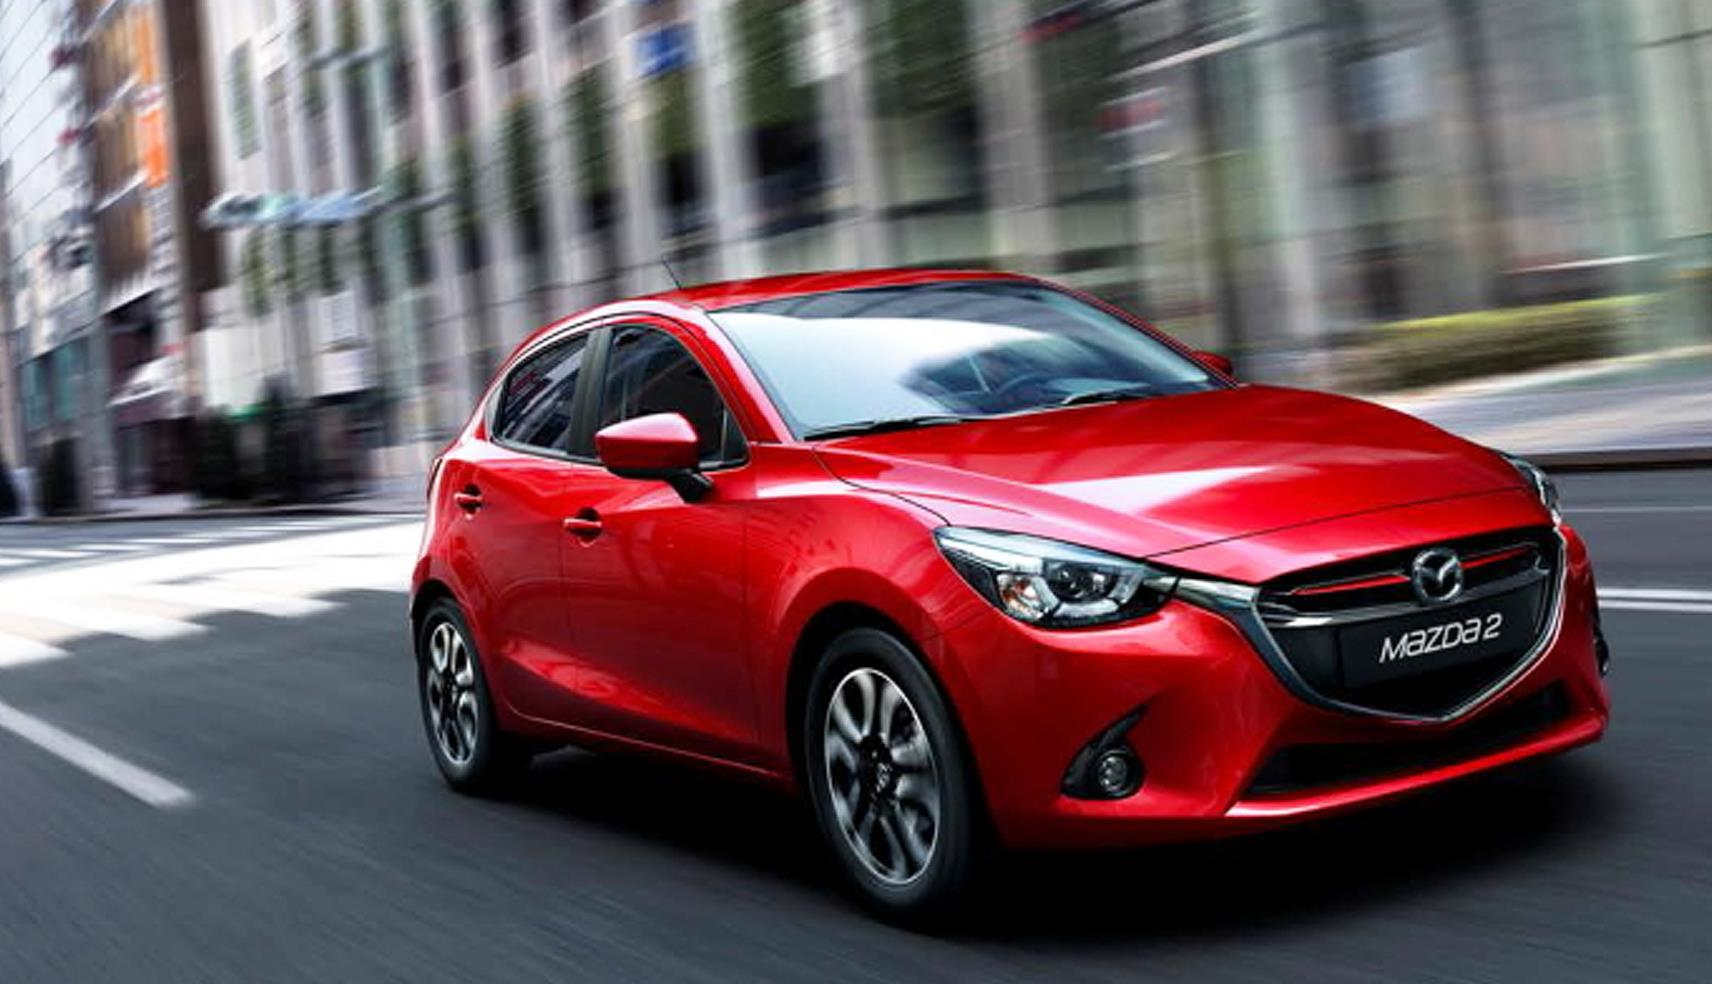

Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.


In [41]:
engine()

Validating that this is a picture of your car...


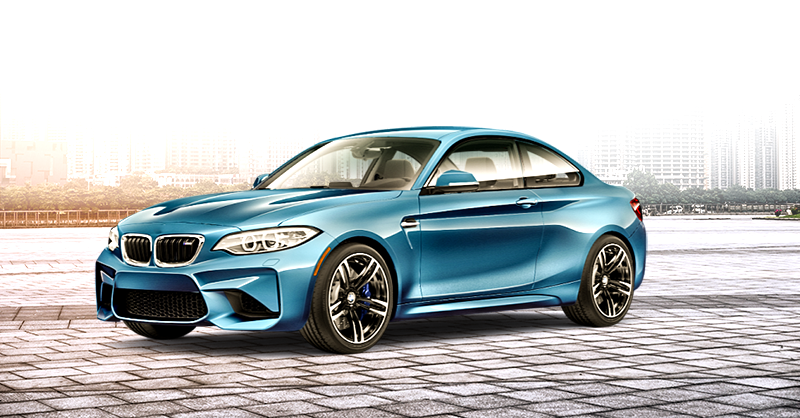

Validating that damage exists...
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting.


In [15]:
engine()

Validating that this is a picture of your car...


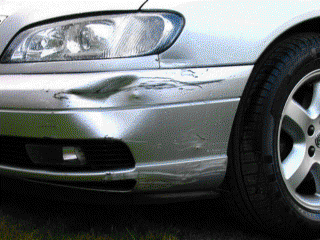

Validating that damage exists...
Determining location of damage...
Assessment: Rear damage to vehicle
Location assessment complete.
Determining severity of damage...
Assessment: Minor damage to vehicle
Severity assessment complete.
Submit image link (or type 'exit' to quit)
Upload Image File Here:exit


In [16]:
engine()